## A motivating example: harmonic oscillator

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1I6sX-yqP__Z3iX-ita-pXi96d-tnZT_S#scrollTo=It1GM_lMFAdf)

### created by Yuying Liu, 11/02/2019

This script provides a toy example of our proposed multiscale HiTS, which is the motivating example (simple linear differential equation for a harmonic oscillator) in our paper, and it can be run on CPU. 

It can be used to reproduce Figure 2.

In [1]:
# imports
import os
import sys
import torch
import numpy as np
import scipy as sp
from scipy import integrate
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings('ignore')

module_path = os.path.abspath(os.path.join('../../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import ResNet as net

In [2]:
# # # # # # # # # # # # # # # # # #
#  global constants, paths, etc.  #
# # # # # # # # # # # # # # # # # #
load_data = False
load_model = False
data_dir = '../../data/Linear/'
model_dir = '../../models/Linear/'

### Simulation

In [3]:
np.random.seed(2)  # for reproduction
dt = 0.001
train_steps = 2000  # at least equal to the largest step size
val_steps = 2000
test_steps = 2000  # t=20
n_train = 500
n_val = 100
n_test = 100
n = 2


if load_data:
    # # # # # # # # # # # # # # # # # # # #
    # load simulated data from directory  #
    # # # # # # # # # # # # # # # # # # # #
    
    train_data = np.load(os.path.join(data_dir, 'train.npy'))
    val_data = np.load(os.path.join(data_dir, 'val.npy'))
    test_data = np.load(os.path.join(data_dir, 'test.npy'))
    n_train = train_data.shape[0]
    n_val = val_data.shape[0]
    n_test = test_data.shape[0]
else:
    # # # # # # # # # # # # 
    # harmonic oscillator #
    # # # # # # # # # # # # 

    # training trajectories
    train_data = np.zeros((n_train, train_steps, n))
    t = np.linspace(0, (train_steps-1)*dt, train_steps)
    print('generating training trials ...')
    for i in tqdm(range(n_train)):
        r0 = np.random.uniform(0, 2)
        phi0 = np.random.uniform(-np.pi, np.pi)
        train_data[i, :, :] = np.array([r0*np.sin(t+phi0), r0*np.cos(t+phi0)]).T
        
    # validating trajectories
    val_data = np.zeros((n_val, val_steps, n))
    t = np.linspace(0, (val_steps-1)*dt, val_steps)
    print('generating validating trials ...')
    for i in tqdm(range(n_val)):
        r0 = np.random.uniform(0, 2)
        phi0 = np.random.uniform(-np.pi, np.pi)
        val_data[i, :, :] = np.array([r0*np.sin(t+phi0), r0*np.cos(t+phi0)]).T

    # testing trajectories
    test_data = np.zeros((n_test, test_steps, n))
    t = np.linspace(0, (test_steps-1)*dt, test_steps)
    print('generating testing trials ...')
    for i in tqdm(range(n_test)):
        r0 = np.random.uniform(0, 2)
        phi0 = np.random.uniform(-np.pi, np.pi)
        test_data[i, :, :] = np.array([r0*np.sin(t+phi0), r0*np.cos(t+phi0)]).T
        
    # save data
    np.save(os.path.join(data_dir, 'train.npy'), train_data)
    np.save(os.path.join(data_dir, 'val.npy'), val_data)
    np.save(os.path.join(data_dir, 'test.npy'), test_data)

generating training trials ...



generating validating trials ...



generating testing trials ...


### Load data

In [4]:
# load the data to dataset object
datasets = list()
step_sizes = list()
print('Dt\'s: ')
for i in range(3, 11):
    step_size = 2**i
    print(step_size * dt)
    step_sizes.append(step_size)
    datasets.append(net.DataSet(train_data, val_data, test_data, dt, step_size=step_size, n_forward=1))

Dt's: 
0.008
0.016
0.032
0.064
0.128
0.256
0.512
1.024


### Train hierarchical neural network time-steppers

In [5]:
models = list()
max_epoch=20000

if load_model:
    # load the model
    for step_size in step_sizes:
        models.append(torch.load(os.path.join(model_dir, 'model_D{}.pt'.format(step_size)), map_location='cpu'))
else:
    for (step_size, dataset) in zip(step_sizes, datasets):
        # set up the network
        model = net.ResNet(arch=[2, 32, 32, 2], dt=dt, step_size=step_size)
        # training
        print('training model_D{} ...'.format(step_size))
        model.train_net(dataset, max_epoch=max_epoch, batch_size=n_train, lr=1e-3, 
                        model_path=os.path.join(model_dir, 'model_D{}.pt'.format(step_size)))
        models.append(model)

training model_D8 ...
epoch 1000, training loss 4.099233592569362e-06, validation loss 4.990076831745682e-06
(--> new model saved @ epoch 1000)
epoch 2000, training loss 1.636853539821459e-06, validation loss 2.1645512333634542e-06
(--> new model saved @ epoch 2000)
epoch 3000, training loss 8.339052328665275e-07, validation loss 1.2134413509556907e-06
(--> new model saved @ epoch 3000)
epoch 4000, training loss 4.6078957893769257e-07, validation loss 7.379697422038589e-07
(--> new model saved @ epoch 4000)
epoch 5000, training loss 2.8116943440181785e-07, validation loss 5.722188802792516e-07
(--> new model saved @ epoch 5000)
epoch 6000, training loss 1.856793261367784e-07, validation loss 5.362145429899101e-07
(--> new model saved @ epoch 6000)
epoch 7000, training loss 1.0765031532855573e-07, validation loss 5.08565108248149e-07
(--> new model saved @ epoch 7000)
epoch 8000, training loss 6.813693431695356e-08, validation loss 4.1499748704154626e-07
(--> new model saved @ epoch 800

epoch 13000, training loss 2.853294347460178e-07, validation loss 3.731333606538101e-07
epoch 14000, training loss 2.256773612430152e-08, validation loss 1.241533027496189e-07
(--> new model saved @ epoch 14000)
epoch 15000, training loss 2.5368596112684827e-08, validation loss 1.281708108535895e-07
epoch 16000, training loss 1.8272418245146582e-08, validation loss 1.336565134124612e-07
epoch 17000, training loss 8.34393958371038e-08, validation loss 2.0842279013777443e-07
epoch 18000, training loss 1.7075986846748492e-08, validation loss 1.389864650036543e-07
epoch 19000, training loss 1.2679543637261759e-08, validation loss 1.3612630311854446e-07
epoch 20000, training loss 1.6075713205054853e-08, validation loss 1.4526126790315175e-07
training model_D128 ...
epoch 1000, training loss 2.903019321820466e-06, validation loss 3.346796802361496e-06
(--> new model saved @ epoch 1000)
epoch 2000, training loss 9.034276331476576e-07, validation loss 1.4807876596023561e-06
(--> new model save

epoch 8000, training loss 1.1157402468597866e-06, validation loss 3.602151082304772e-06
(--> new model saved @ epoch 8000)
epoch 9000, training loss 7.239510182444064e-07, validation loss 2.777769168460509e-06
(--> new model saved @ epoch 9000)
epoch 10000, training loss 1.021942580337054e-06, validation loss 2.4481178115820512e-06
(--> new model saved @ epoch 10000)
epoch 11000, training loss 5.632743068417767e-06, validation loss 6.79248205415206e-06
epoch 12000, training loss 4.038915051296499e-07, validation loss 1.61265245424147e-06
(--> new model saved @ epoch 12000)
epoch 13000, training loss 3.5258406683169596e-07, validation loss 1.344602765129821e-06
(--> new model saved @ epoch 13000)
epoch 14000, training loss 2.871556716854684e-07, validation loss 1.170331302091654e-06
(--> new model saved @ epoch 14000)
epoch 15000, training loss 2.5277157078562595e-07, validation loss 1.09883512777742e-06
(--> new model saved @ epoch 15000)
epoch 16000, training loss 8.867930773703847e-0


use models 2 - 6.


(array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

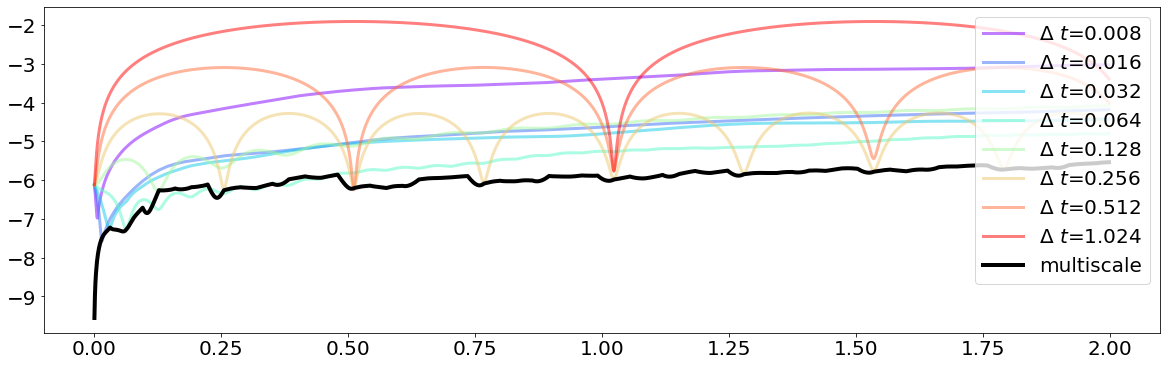

In [6]:
criterion = torch.nn.MSELoss(reduction='none')

# uniscale time-stepping with NN
preds_mse = list()
for model in tqdm(models):
    y_preds = model.uni_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=test_steps-1)
    preds_mse.append(criterion(torch.tensor(test_data[:, 1:, :]).float(), y_preds).mean(-1))
    
# model selections 
start_idx = 0
end_idx = len(models)
best_mse = 1e+5

# choose the largest time step
for i in tqdm(range(len(models))):
    y_preds = net.vectorized_multi_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=test_steps-1, models=models[:len(models)-i])
    mse = criterion(torch.tensor(test_data[:, 1:, :]).float(), y_preds).mean().item()
    if mse <= best_mse:
        end_idx = len(models)-i
        best_mse = mse

# choose the smallest time step
for i in tqdm(range(end_idx)):
    y_preds = net.vectorized_multi_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=test_steps-1, models=models[i:end_idx])
    mse = criterion(torch.tensor(test_data[:, 1:, :]).float(), y_preds).mean().item()
    if mse <= best_mse:
        start_idx = i
        best_mse = mse
        
print('use models {} - {}.'.format(start_idx, end_idx))
models = models[start_idx:end_idx]

# multiscale time-stepping with NN
y_preds = net.vectorized_multi_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=test_steps-1, models=models)
multiscale_preds_mse = criterion(torch.tensor(test_data[:, 1:, :]).float(), y_preds).mean(-1)
multiscale_err = multiscale_preds_mse.mean(0).detach().numpy()
    
# visualize forecasting error at each time step    
fig = plt.figure(figsize=(20, 6))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(datasets))))
for k in range(len(preds_mse)):
    err = preds_mse[k]
    mean = err.mean(0).detach().numpy()
    rgb = next(colors)
    plt.plot(t[:-1], np.log10(mean), linestyle='-', color=rgb, linewidth=3.0, alpha=0.5, label='$\Delta\ t$={}'.format(step_sizes[k]*dt))
plt.plot(t[:-1], np.log10(multiscale_err), linestyle='-', color='k', linewidth=4.0, label='multiscale')
plt.legend(fontsize=20, loc='upper right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)